In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.regularizers import l2

import numpy as np
import tensorflow as tf
import scipy.stats as st
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('candy_production.csv', header=0, index_col = 0,squeeze=True)
raw_values = df.values
raw_keys = df.keys()

In [3]:
# Look at the first 5 entries and plot the series
plt.xlabel("Date")
plt.ylabel("Production")
df.plot()
df.head(5)

Date
1/1/1972    85.6945
2/1/1972    71.8200
3/1/1972    66.0229
4/1/1972    64.5645
5/1/1972    65.0100
Name: IP, dtype: float64

In [4]:
def to_stationary(dataset, interval=1):
    '''Routine that takes the original time series
       and remove any trend.'''
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame(diff)

In [5]:
def inverse_stationary(history, yhat, interval=1):
    '''Takes the stationary time series and reverts back 
       to original time series with trends.'''
    inverted = list()
    for i in range(0,len(yhat)):
        value = yhat[i] + history[-(len(history)-i)]
        inverted.append(value)
    return pd.DataFrame(inverted)

In [6]:
def inverse_stationary2(history, yhat, interval=1):
    return yhat + history[-interval]

In [7]:
raw_values_stationary = to_stationary(raw_values, 1)
inverted = inverse_stationary(raw_values, raw_values_stationary.values, 1)

In [8]:
print(df.head(5))
print(raw_values_stationary.head(5))
print(inverted.head(5))

Date
1/1/1972    85.6945
2/1/1972    71.8200
3/1/1972    66.0229
4/1/1972    64.5645
5/1/1972    65.0100
Name: IP, dtype: float64
         0
0 -13.8745
1  -5.7971
2  -1.4584
3   0.4455
4   2.6367
         0
0  71.8200
1  66.0229
2  64.5645
3  65.0100
4  67.6467


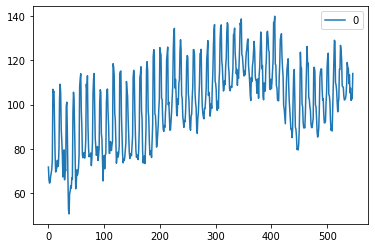

In [9]:
#-- Check by plotting
df.plot()
raw_values_stationary.plot()
inverted.plot()

In [10]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [11]:
supervised = timeseries_to_supervised(raw_values_stationary, lag=1)
supervised_val = supervised.values

In [12]:
splitIdx = int(len(supervised_val) * 0.8)
train, test = supervised_val[0:splitIdx], supervised_val[splitIdx:]
#print(splitIdx)
#print(len(test))

In [13]:
def scale(train, test):
    '''Scale the supervised time series data to 
       oscillate between -1 to 1.'''
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    
    # Transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # Transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [14]:
def invert_scale(scaler, X, value):
    '''Reverses the scaling done on the 
       time series data.'''
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0,-1]

In [15]:
scaler, train_scaled, test_scaled = scale(train, test)

In [16]:
#-- Initialize parameters for LSTM model
look_back       = 1
batch_size      = 1
lbd             = 1e-4    # For l2 regularization
p_drop          = 0.5     # dropout rate for LSTM layer, dropout
p_dropRecurrent = 0.25    # dropout rate for LSTM layer, recurrent dropout
p_dropDense     = 0.1     # dropout rate for Dense layer

#-- Separate sets into X and y components
Xtrain, ytrain = train_scaled[:,0:-1], train_scaled[:,-1]
Xtest, ytest = test_scaled[:,0:-1], test_scaled[:,-1]

#-- Reshape X sets for LSTM model
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, Xtrain.shape[1])
Xtest = Xtest.reshape(Xtest.shape[0], 1, Xtest.shape[1])

In [17]:
Xtrain[0].shape

(1, 1)

In [18]:
# Sequential API

#-- Construct LSTM model
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back,1), 
               dropout=p_drop, recurrent_dropout=p_dropRecurrent,
               stateful=True, kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropDense))
model.add(Dense(1, kernel_regularizer=l2(lbd)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 4)                    96        
_________________________________________________________________
dropout (Dropout)            (1, 4)                    0         
_________________________________________________________________
dense (Dense)                (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [19]:
#-- Train the model
model.fit(Xtrain,ytrain, epochs=25, batch_size=batch_size, verbose=2, shuffle=False)

Epoch 1/25
437/437 - 1s - loss: 0.0948
Epoch 2/25
437/437 - 1s - loss: 0.0889
Epoch 3/25
437/437 - 1s - loss: 0.0906
Epoch 4/25
437/437 - 1s - loss: 0.0899
Epoch 5/25
437/437 - 1s - loss: 0.0887
Epoch 6/25
437/437 - 1s - loss: 0.0872
Epoch 7/25
437/437 - 1s - loss: 0.0879
Epoch 8/25
437/437 - 1s - loss: 0.0873
Epoch 9/25
437/437 - 1s - loss: 0.0869
Epoch 10/25
437/437 - 1s - loss: 0.0883
Epoch 11/25
437/437 - 1s - loss: 0.0874
Epoch 12/25
437/437 - 1s - loss: 0.0860
Epoch 13/25
437/437 - 1s - loss: 0.0872
Epoch 14/25
437/437 - 1s - loss: 0.0864
Epoch 15/25
437/437 - 1s - loss: 0.0859
Epoch 16/25
437/437 - 1s - loss: 0.0839
Epoch 17/25
437/437 - 1s - loss: 0.0882
Epoch 18/25
437/437 - 1s - loss: 0.0836
Epoch 19/25
437/437 - 1s - loss: 0.0838
Epoch 20/25
437/437 - 1s - loss: 0.0832
Epoch 21/25
437/437 - 1s - loss: 0.0829
Epoch 22/25
437/437 - 1s - loss: 0.0809
Epoch 23/25
437/437 - 1s - loss: 0.0820
Epoch 24/25
437/437 - 1s - loss: 0.0818
Epoch 25/25
437/437 - 1s - loss: 0.0854


In [20]:
def lstm_forecast(model, batch_size, X):
    '''Takes the trained LSTM model and make
       prediction.'''
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [24]:
#-- Compare the predicted values of LSTM model and original time series

predictions = []
expectations = []
for i in range(0,len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = lstm_forecast(model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_stationary2(raw_values, yhat, len(test_scaled)+1 - i)
    predictions.append(yhat)
    expected = raw_values[len(train) + i]
    expectations.append(expected)
for i in range(0,36):
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=103.856324, Expected=102.586100
Month=2, Predicted=103.856324, Expected=102.586100
Month=3, Predicted=103.856324, Expected=102.586100
Month=4, Predicted=103.856324, Expected=102.586100
Month=5, Predicted=103.856324, Expected=102.586100
Month=6, Predicted=103.856324, Expected=102.586100
Month=7, Predicted=103.856324, Expected=102.586100
Month=8, Predicted=103.856324, Expected=102.586100
Month=9, Predicted=103.856324, Expected=102.586100
Month=10, Predicted=103.856324, Expected=102.586100
Month=11, Predicted=103.856324, Expected=102.586100
Month=12, Predicted=103.856324, Expected=102.586100
Month=13, Predicted=103.856324, Expected=102.586100
Month=14, Predicted=103.856324, Expected=102.586100
Month=15, Predicted=103.856324, Expected=102.586100
Month=16, Predicted=103.856324, Expected=102.586100
Month=17, Predicted=103.856324, Expected=102.586100
Month=18, Predicted=103.856324, Expected=102.586100
Month=19, Predicted=103.856324, Expected=102.586100
Month=20, Predicted=1

0.9738435674107344

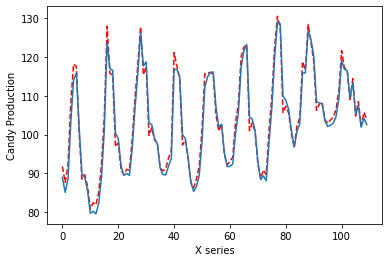

In [22]:
#-- Plot the results
#-- Red, Dashed = LSTM model
#-- Blue = Original time series
plt.xlabel('X series')
plt.ylabel('Candy Production')
plt.plot(predictions,'r--')
plt.plot(expectations)
metrics.r2_score(expectations, predictions)